In [3]:
import fiona
import osmnx as ox
import shapely
import math
import pyproj
import sys

import numpy as np
import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd

from matplotlib import pyplot
from functools import partial
from shapely import geometry
from shapely.ops import transform
from descartes import PolygonPatch
from matplotlib.patches import Arc
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
%matplotlib inline

### CUSTOM CLASSES
sys.path.append('../../../alg')
import distance_buffer as db
import border_generators as bg
import marching_army as ma

In [4]:
from scipy.stats import truncnorm

In [5]:
reload(bg)

<module 'border_generators' from '../../../alg/border_generators.pyc'>

In [6]:
reload(db)

<module 'distance_buffer' from '../../../alg/distance_buffer.pyc'>

In [47]:
reload(ma)

<module 'marching_army' from '../../../alg/marching_army.py'>

# Intelligent Shifting / Rotating
- want to intelligently shift (U/D/L/R) in combo w/ rotating (CW/CCW) to get the best coverage with the lowest amount of circles
- **NOTE: INTELLIGENT S/R SHOULD BE APPLIED AFTER THE POPULATION CENTERS ARE TAKEN INTO ACCOUNT (BC IT WILL CHANGE OUTCOME)**

In [8]:
##############################################

### Get the place and show it 

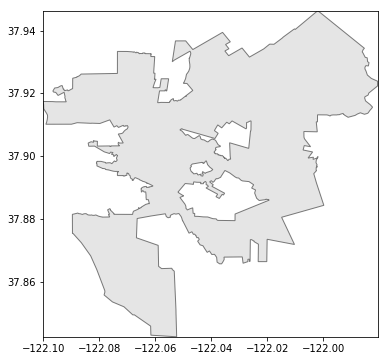

In [9]:
gdf, placegeom = bg.getplace('Walnut Creek, California, USA')
# plot the city
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in placegeom:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [11]:
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),pyproj.Proj(init='epsg:3857'))
transgeom = transform(proj, placegeom)
transgeom = transgeom[0]

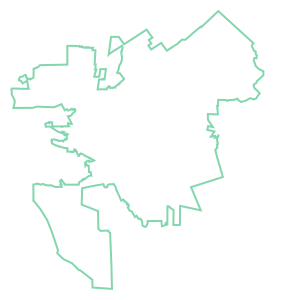

In [12]:
transgeom.exterior

In [13]:
from shapely.geometry import LineString

In [17]:
bounds = transgeom.bounds
start_line, pt1,pt2 = ma.gen_starting_line(bounds)
print bounds
print start_line
print pt1,pt2

intpt = intersect_line_region(pt1, start_line, transgeom.exterior)
print intpt

randpts = ma.gen_rand_pt_on_line(pt1, pt2, start_line, transgeom)
print randpts



(-13592126.456990628, 4557195.678592932, -13578819.013366627, 4571847.8160177665)
[ 0.99979529 -0.0202333 ]
[-13586919.95405477   4565302.17190232] [-13583661.05452032   4565236.22010041]
2
LINESTRING (-13589308.42239864 4565350.508400397, -13589240.31047267 4565349.129989004, -13589175.11542758 4565347.810607828, -13581382.55201223 4565190.109029947, -13581318.14091041 4565188.80551378, -13581228.7138237 4565186.995737981)
[-13589094.71034869   4565346.18341442]


In [15]:
def intersect_line_region(pt1,linevec, poly):
    
    intpt = []
    i = 1
    while len(intpt) < 2:
    #    # the line is a unit vector, get it long enough to make sure it intersects before we return the pt
        temp1 = pt1+ (100000.0*i)*linevec
        temp2 = pt1 - (100000.0*i)*linevec
        newline = LineString([temp1,temp2])
        intpt = newline.intersection(poly)
        i+=1
        print i
    
    return LineString(intpt)

In [28]:

%%time
candptsalltry2, borderpts, stpts = ma.gen_cand_pts(transgeom, start_line, randpts, 100.0)#, bounds)


CPU times: user 1min 19s, sys: 120 ms, total: 1min 19s
Wall time: 1min 19s


In [40]:
%%time
candptsalltry3, borderpts3, stpts3 = ma.gen_cand_pts(transgeom, start_line, randpts, 100.0)#, bounds)


CPU times: user 1min 18s, sys: 90.5 ms, total: 1min 18s
Wall time: 1min 18s


In [48]:
%%time
candptsalltry4, borderpts4, stpts4 = ma.gen_cand_pts(transgeom, start_line, randpts, 100.0)#, bounds)


CPU times: user 1min 27s, sys: 308 ms, total: 1min 27s
Wall time: 1min 28s


In [41]:
print len(candptsalltry3)
print(bounds)

99
(-13592126.456990628, 4557195.678592932, -13578819.013366627, 4571847.8160177665)


In [44]:
print stpts3[0]

IndexError: list index out of range

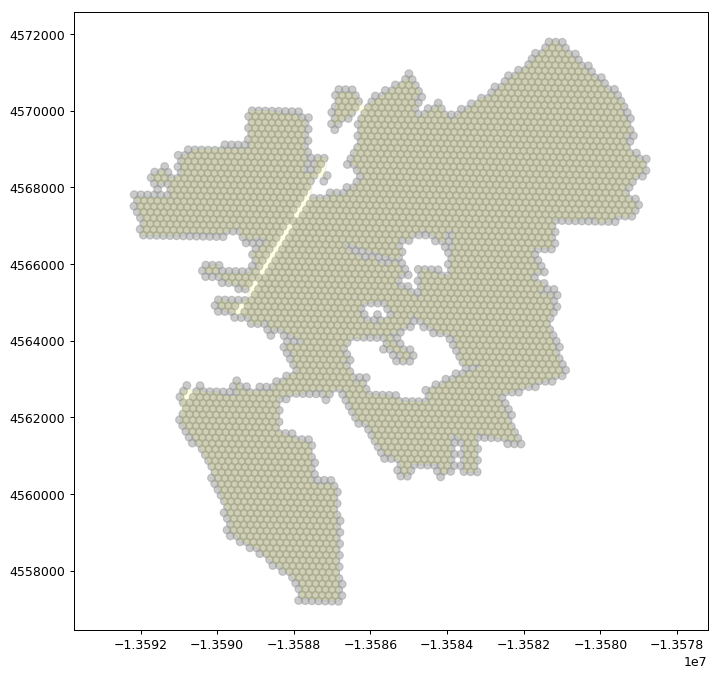

In [49]:
ax1, fig1 = db.plot_fig(transgeom)
#db.plot_line(ax, intpt.coords,ls='-',color='red',zorder=2)

#for i in range(0, len(stpts)):
#ax1.scatter( stpts[0][0],stpts3[0][1], alpha=0.5, color="red")
for i in range(0, len(candptsalltry4)):
    db.plot_radii(ax1, candptsalltry4[i], 100.0, alpha=0.5)

    
for i in range(0, len(borderpts)):
    db.plot_radii(ax1, borderpts[i], 100.0, alpha=0.5, color="pink")
#ax.plot(candptsalltry1[9][0][0], candptsalltry1[9][0][1], 'o', color='green', alpha=0.5)
#ax.plot(candptsalltry1[0][0][0], candptsalltry1[0][0][1], 'o', color='purple', alpha=0.5)

pyplot.show()

In [ ]:
ax2, fig2 = db.plot_fig(transgeom)
#db.plot_line(ax, intpt.coords,ls='-',color='red',zorder=2)

for i in range(0, len(candptsalltry2)):
    db.plot_radii(ax2, candptsalltry2[i], 100.0, alpha=0.5)
    
for i in range(0, len(borderpts)):
    db.plot_radii(ax1, borderpts[i], 100.0, alpha=0.5, color="pink")
#ax.plot(candptsalltry1[9][0][0], candptsalltry1[9][0][1], 'o', color='green', alpha=0.5)
#ax.plot(candptsalltry1[0][0][0], candptsalltry1[0][0][1], 'o', color='purple', alpha=0.5)

pyplot.show()

In [ ]:
def gen_cand_pts_on_line(poly, linevec, startpt, r, bds):
    #main algorithm, start from the randomly generated intersecting line & then 
    # keeps track of running missed pts; stop once we get to a thresh
    
    eps = 0.01 # epsilon for tolerance of intersection of region and coverage area(r)
    covarea = math.pi*r*r
    nummissedpts = 0
    pt = startpt
    candpts = []
    tempregion = poly
    regiondiff = poly.difference(Point(startpt).buffer(r))
    bordercands = []
    lastpt = startpt

            
    if regiondiff.area < tempregion.area:
        candpts.append(startpt)
    optdist = np.sqrt(3)*r
            
    tempregion = regiondiff
    while nummissedpts < 100:
            temppt = pt + optdist*linevec
            pt = temppt
            if (lastpt[0] < bds[0] or lastpt[1] < bds[1] or lastpt[0] > bds[2] or lastpt[1] > bds[3]):
                #nummissedpts += 1
                break
            else:
                regiondiff = tempregion.difference(Point(pt).buffer(r))
                rdarea = regiondiff.area
                trarea = tempregion.area
                if rdarea < trarea:
                    candpts.append(temppt)
                    tempregion = regiondiff
                    nummissedpts = 0
                    lastpt = temppt
                #if (trarea - rdarea) < covarea:
                    # this means the new candpt's covarea is on a border/hole
                #    bordercands.append(temppt)
                else:
                    nummissedpts+=1
                
    
    
    #print "MOVE TO NEG DIR PT LOOP "+ str(len(candpts))
    
    
    nummissedpts = 0
    pt = startpt
    tempregion = regiondiff
    while nummissedpts < 100:
            temppt = pt - optdist*linevec
            pt = temppt

            if (lastpt[0] < bds[0] or lastpt[1] < bds[1] or lastpt[0] > bds[2] or lastpt[1] > bds[3]):
                #nummissedpts += 1
                break
            else:
                regiondiff = tempregion.difference(Point(pt).buffer(r))
                rdarea = regiondiff.area
                trarea = tempregion.area
                if rdarea < trarea:
                    candpts.append(temppt)
                    tempregion = regiondiff
                    nummissedpts = 0
                    lastpt = temppt
                #if (trarea - rdarea) < covarea:
                    # this means the new candpt's covarea is on a border/hole
                #    bordercands.append(temppt)
                else:
                    nummissedpts+=1

    return candpts, bordercands#, tempregion



In [ ]:
def gen_cand_pts(poly, startvec, startpt, r, bds):
    nummissedlines = 0
    candpts = []
    borderpts = []
    nextstpt = startpt
    #tempregions = []
    tempregion = poly
    #positive direction loop
    while nummissedlines < 100:
        temppts, tempbpts = gen_cand_pts_on_line(tempregion, startvec, nextstpt, r, bds)
        if len(temppts) > 1:
            candpts.append(temppts)
            borderpts.append(tempbpts)
            #tempregions.append(tempregion)
            nextstpt = ma.gen_next_line_startpt(nextstpt, startvec, r)
            nummissedlines=0
        else:
            nummissedlines+=1
            
    nummissedlines=0
    
    #print "MOVE TO NEG DIR LINE LOOP "+ str(len(tempregions))
    nextstpt = ma.gen_next_line_startpt(startpt, startvec, -1*r)
    while nummissedlines < 100:
        temppts, tempbpts = gen_cand_pts_on_line(tempregion, startvec, nextstpt, r, bds)
        if len(temppts) > 1:
            candpts.append(temppts)
            borderpts.append(tempbpts)
            #tempregions.append(tempregion)
            nextstpt = ma.gen_next_line_startpt(nextstpt, startvec, -1*r)
            nummissedlines=0
        else:
            nummissedlines+=1     
    return candpts, borderpts#, tempregions

# Generate population locations

In [ ]:
# code in this block is from:
# https://stackoverflow.com/questions/36894191/how-to-get-a-normal-distribution-within-a-range-in-numpy

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [ ]:
X_x = get_truncated_normal(0, 1, bds[0], bds[2])
X_y = get_truncated_normal(0,1,bds[1],bds[3])

In [ ]:
pops = []
tempx = X_x.rvs(1000)
tempy = X_y.rvs(1000)

for i in range(0,1000):
    pops.append(Point(tempx[i],tempy[i]))